# 1. Setup

## 1.1 Import Drivers

In [2]:
import logging
from logging import getLogger
import sys
import pynq
import time
from pynq import PL
import os, time

import numpy as np
from fpbinary import FpBinary
import matplotlib.pyplot as plt
from scipy.fftpack import fft, fftfreq, fftshift
import scipy.io as sio

from pynq import Overlay
import mkidgen3 as g3
import mkidgen3.mkidpynq as mkidpynq
import mkidgen3.util
import mkidgen3.plotting
from mkidgen3.plotting import plot_waveforms, plot_res_chan
from mkidgen3.daccomb import generate_dac_comb
from mkidgen3.drivers import axiswitch, bintores, capture, ddc, dactable, axififo, rfdc, ddssweep
from mkidgen3.server.feedline_config import *
from mkidgen3.util import setup_logging
from mkidgen3.server.waveform import WaveformFactory
import matplotlib.style as style

## 1.2 Setup Logging, Clocking, and Download Overlay

In [2]:
#logging.basicConfig(level=logging.DEBUG) # Sets the logging level to DEBUG

In [3]:
# Download Overlay, Optionally Configure Clocks
bitstream='/home/xilinx/bit/adc_downconvert_test.bit'
mkidgen3.drivers.rfdcclock.configure(programming_key='4.096GSPS_MTS_dualloop',clock_source='internal')
time.sleep(0.5)
ol = Overlay(bitstream, ignore_version=True, download=True)
mkidgen3.quirks.Overlay(ol).post_configure()
ol.rfdc.enable_mts()

# PL DDS
By default, the PL DDS will play an identity waveform so while it is running, the typical notebook functions should work as normal and appear as if there is no PL DDS.

At any point, the PL DDS can be returned to this state by programming the output frequency to be zero or by using the convenience `off` method:

In [4]:
#ol.freq_sweep.PL_DDS.dds_pinc_1.configure(0)
#ol.freq_sweep.PL_DDS.dds_pinc_1.off()

Program the PL DDS by specifying the output frequency in Hz. The core can output frequencies between 0 and 128 MHz with 7.8125 kHz resolution. In practice, the PL DDS qualility drops at higher frequencies so best to keep it in 0-5 MHz.

In [13]:
pl_dds_freq = 0.5e6#7.8125e3*10
ol.freq_sweep.PL_DDS.dds_pinc_1.configure(pl_dds_freq)

## 2.1 Play Waveform

In [4]:
tones = np.array([500.0e6])
amplitudes = np.full(tones.size, fill_value=0.8/tones.shape[0])

In [5]:
waveform = WaveformConfig(waveform=WaveformFactory(frequencies=tones, amplitudes=amplitudes))

In [6]:
ol.dac_table.configure(**waveform.settings_dict())

## 2.2 ADC Capture

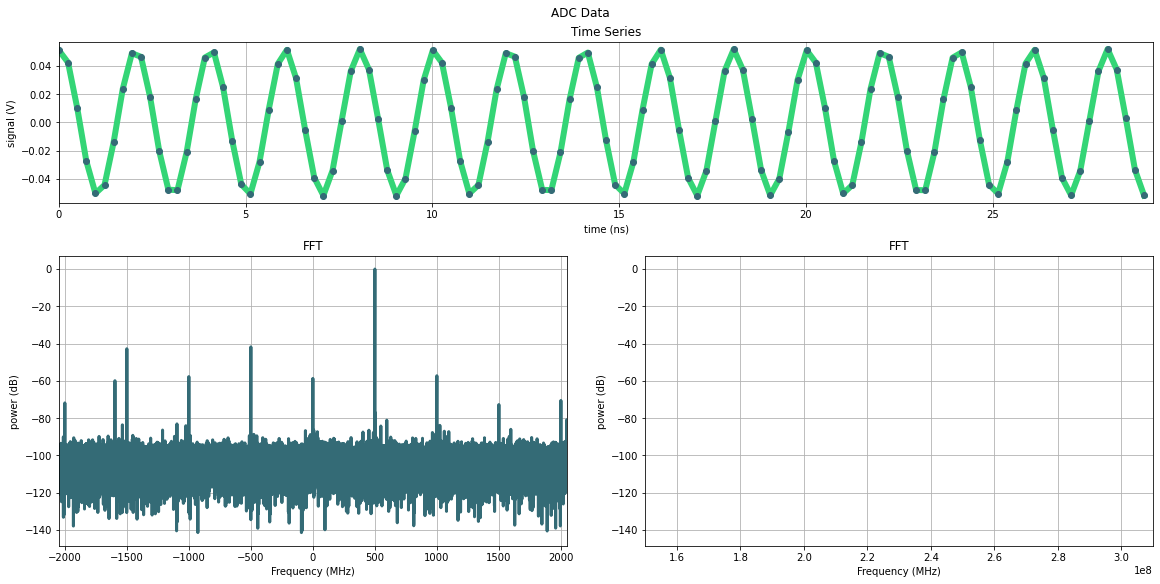

In [14]:
# Trigger Capture
x = ol.capture.capture_adc(2**19, complex=False)  # throw away capture to clear any startup garbage
del x
adc_capture_data = ol.capture.capture_adc(2**19, complex=True)
adc_capture_data/=2**16  #Normalize to 1/2 V
## Plot ADC Data
timerange = (0,120)  # ns
fftrange= (16, 16 + 20*4096) 
fftzoom = (1.5e8, 3.1e8)
mkidgen3.plotting.adc_test_plot(adc_capture_data, timerange, fftrange, fftzoom)

# Pretty Sweep Plot

In [17]:
tone_f = waveform.waveform.freqs[0]
fs=4.096e9
samples=2**19
fft_res = fs/samples
freqs = np.linspace(-fs/2, (fs/2)-fft_res, samples)

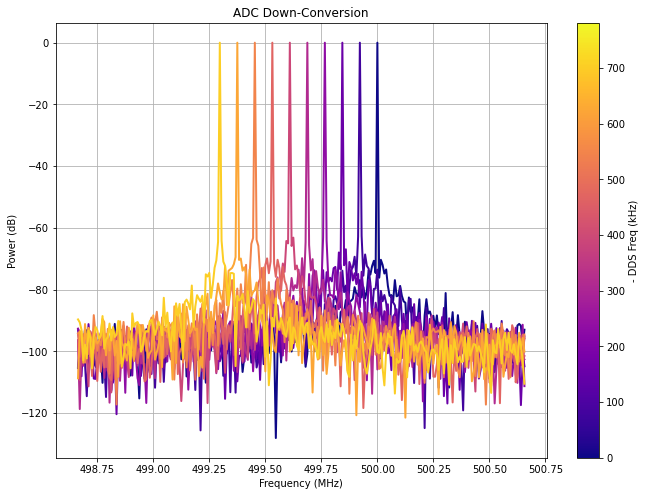

In [19]:
# Freq Zoom
freq_zoom = 2e6 # [Hz]
tone_sl = slice(np.argmin(np.abs(freqs-(tone_f-freq_zoom*(2/3)))),np.argmin(np.abs(freqs-(tone_f+freq_zoom*(1/3)))))

npts = 10

# Plot Colors
import matplotlib.colors as cl
import matplotlib.cm as cm
cmap = plt.cm.plasma # Change colot map here
norm = cl.Normalize(0,npts*7812.5*10*1e-3) # Should match max and min PL DDS values in kHz
smap = cm.ScalarMappable(norm, cmap)

fig, ax = plt.subplots(1, figsize=(11,8))

for freq_steps in range(npts):
    # Set PL DDS
    dds_freq = freq_steps*7812.5*10 # PL DDS freq in Hz (steps of 10x max resolution)
    ol.freq_sweep.PL_DDS.dds_pinc_1.configure(dds_freq) # program PL DDS
    
    # Capture Data
    x = ol.capture.capture_adc(2**19, complex=False)
    del x
    adc_capture_data = ol.capture.capture_adc(2**19, complex=True)
    adc_capture_data/=2**16  #Normalize to 1/2 V
    
    # Take FFT of Data
    adc_fft = 20*np.log10(np.abs((np.fft.fftshift(np.fft.fft(adc_capture_data)))))
    del adc_capture_data
    
    # Plot Data
    color=cmap(norm(dds_freq*1e-3)) # set color from color map
    ax.plot(freqs[tone_sl]*1e-6,adc_fft[tone_sl] - adc_fft.max(), linewidth=2, color=color)

ax.grid(True)
ax.set_xlabel('Frequency (MHz)')
ax.set_ylabel('Power (dB)')
ax.set_title('ADC Down-Conversion')
fig.colorbar(smap, ax=ax, label="- DDS Freq (kHz)");